** Calculate Spatial Relationships **  

Split polylines into segments based on azimuth changes.
Calculate parameters for line segments and assign values to nearest points, including azimuth, length, and the nearest distance to points (from start to endpoints of segments).
Calculate the distance and angle between two segments of lines and assign values to the nearest points.  
Inputs are two lines (here are the craton and rift lines) and one point (here is the deposit location) in ".shp" format.  
At the end, we will extract 8 key parameters:

1- craton_dis: The minimum distance from craton segments (line 1) to the nearest deposit (point).  
2- craton_az: The azimuth of craton segments (line 1), assigned to the nearest deposit (point).  
3- craton_len: The length of craton segments (line 1), assigned to the nearest deposit (point).  
4- rift_dis: The minimum distance from rift segments (line 2) to the nearest deposit (point).  
5- rift_az: The azimuth of rift segments (line 2), assigned to the nearest deposit (point).  
6- rift_len: The length of rift segments (line 2), assigned to the nearest deposit (point).  
7- seg_dis: The distance between craton and rift segments (line 1 and line 2), assigned to the nearest deposit (point).  
8- seg_angle: The smallest angle between craton and rift segments (line 1 and line 2), assigned to the nearest deposit (point).  

These parameters provide valuable spatial relationships between geological features (lines) and deposits (points).  

The final output will be: "merged_segmented_rift" (line 1), "merged_segmented_craton" (line 2), and "Deposits_SpatialRelationships" (point).  
"Deposits_SpatialRelationships" (point) will carry all 8 extracted parameters

** Importing Libraries **

In [24]:
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString, Point, MultiLineString
import math
from shapely.ops import linemerge

# 1- Split_polyline_based_on_azimuth

## Segment craton (line 1)

In [25]:
# This function calculates the great-circle distance and azimuth (direction) between two geographical points on Earth's surface using the Haversine formula.
def haversine_distance_and_azimuth(point1, point2):
    """
    Calculate the great-circle distance and azimuth between two points on the Earth's surface.
    """
    R = 6371  # Earth's radius in kilometers (At the equator, the Earth's radius is about 6378 km. At the poles, the Earth's radius is about 6356 km. Adjust it based on your study area)

    lat1, lon1 = np.radians(point1.y), np.radians(point1.x)
    lat2, lon2 = np.radians(point2.y), np.radians(point2.x)

    d_lat = lat2 - lat1
    d_lon = lon2 - lon1

    # Haversine distance calculation
    a = np.sin(d_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    # Azimuth calculation
    x = np.sin(d_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)

    azimuth = np.arctan2(x, y)
    azimuth = np.degrees(azimuth)
    azimuth = (azimuth + 360) % 360  # Normalize to [0, 360] degrees

    # Adjust azimuth: if greater than 180°, subtract 180°
    # Normalize to [0, 180] degrees
    if azimuth > 180:
        azimuth = azimuth - 180
       
    return distance, azimuth

# This function computes the smallest angle difference between two azimuths, ensuring that the result is between 0 and 90°
def smallest_angle_difference(azimuth1, azimuth2):
    """
    Calculate the smallest angle difference between two azimuths.
    """
    difference = abs(azimuth1 - azimuth2) % 180
    return min(difference, 180 - difference)

# This function interpolates points along a polyline at regular intervals, based on a specified distance in kilometers.
def interpolate_points(line, interval_km):
    interpolated_points = []
    total_length = 0
    previous_point = Point(line.coords[0])

    interpolated_points.append(previous_point)

    for i in range(1, len(line.coords)):
        current_point = Point(line.coords[i])
        segment_distance, _ = haversine_distance_and_azimuth(previous_point, current_point)
        total_length += segment_distance

        if total_length >= interval_km:
            interpolated_points.append(current_point)
            total_length = 0  # Reset for the next interval

        previous_point = current_point

    return interpolated_points

# This function splits polylines from a shapefile into segments based on changes in azimuth, ensuring that the azimuth change between segments does not exceed a given threshold.
def split_polyline_based_on_azimuth(shapefile, interval_km=50, threshold=30):
    gdf = gpd.read_file(shapefile)
    segmented_lines = []
    segment_ids = []
    segment_azimuths = []
    plate_ids = []
    segment_counter = 1
    
    for idx, row in gdf.iterrows():
        line = row.geometry
        plate_id = row['PLATEID1']
        interpolated_points = interpolate_points(line, interval_km)
        
        if len(interpolated_points) < 2:
            continue
        
        current_segment = [interpolated_points[0]]
        _, previous_azimuth = haversine_distance_and_azimuth(interpolated_points[0], interpolated_points[1])
        
        for i in range(1, len(interpolated_points)):
            point1 = interpolated_points[i - 1]
            point2 = interpolated_points[i]
            _, current_azimuth = haversine_distance_and_azimuth(point1, point2)
            
            # Calculate the azimuth between the start and end of the current segment
            _, segment_azimuth = haversine_distance_and_azimuth(current_segment[0], point2)
            
            azimuth_change = smallest_angle_difference(current_azimuth, segment_azimuth)
            
            # Ensure the segments are contiguous and azimuth difference is within the threshold
            if azimuth_change > threshold or not Point(current_segment[-1]).equals(Point(point1)):
                # Finalize current segment and start a new one
                current_segment.append(point1)
                if len(current_segment) > 1:
                    _, avg_azimuth = haversine_distance_and_azimuth(current_segment[0], current_segment[-1])
                    segmented_lines.append(LineString(current_segment))
                    segment_ids.append(segment_counter)
                    segment_azimuths.append(avg_azimuth)
                    plate_ids.append(plate_id)
                    segment_counter += 1
                current_segment = [point1]
            
            current_segment.append(point2)
            previous_azimuth = current_azimuth
        
        # Add the final segment
        if len(current_segment) > 1:
            _, avg_azimuth = haversine_distance_and_azimuth(current_segment[0], current_segment[-1])
            segmented_lines.append(LineString(current_segment))
            segment_ids.append(segment_counter)
            segment_azimuths.append(avg_azimuth)
            plate_ids.append(plate_id)
            segment_counter += 1

    # Retain my columns
    segmented_gdf = gpd.GeoDataFrame({
        'segment_id': segment_ids,
        'azimuth': segment_azimuths,
        'PLATEID1': plate_ids,
        'geometry': segmented_lines
    }, crs=gdf.crs)
    
    output_shapefile = "./Datasets/segmented_craton.shp"
    segmented_gdf.to_file(output_shapefile)
    print(f"Segmented polylines saved to {output_shapefile}")

# Example usage:
split_polyline_based_on_azimuth("./Datasets/Craton_Line.shp", interval_km=50, threshold=30)


Segmented polylines saved to ./Datasets/segmented_craton.shp


## Post-Processing

In [26]:
 # Use the new function to identify and merge segments that have a small angle difference, even after segmentation.

In [27]:
def haversine_distance_and_azimuth(point1, point2):
    R = 6371  # Earth's radius in kilometers

    lat1, lon1 = np.radians(point1.y), np.radians(point1.x)
    lat2, lon2 = np.radians(point2.y), np.radians(point2.x)

    d_lat = lat2 - lat1
    d_lon = lon2 - lon1

    a = np.sin(d_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    x = np.sin(d_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)

    azimuth = np.arctan2(x, y)
    azimuth = np.degrees(azimuth)
    azimuth = (azimuth + 360) % 360

    if azimuth > 180:
        azimuth = azimuth - 180
       
    return distance, azimuth

def smallest_angle_difference(azimuth1, azimuth2):
    difference = abs(azimuth1 - azimuth2) % 180
    return min(difference, 180 - difference)

def are_lines_connected(line1, line2):
    """
    Check if two lines are connected (i.e., they share an endpoint).
    """
    return line1.coords[-1] == line2.coords[0] or line1.coords[0] == line2.coords[-1]

def merge_connected_segments(gdf, threshold=30):
    merged_segments = []
    merged_ids = []
    merged_azimuths = []
    merged_plate_ids = []
    used = set()
    
    for i, geom1 in gdf.iterrows():
        if i in used:
            continue
        
        segment_to_merge = [geom1.geometry]
        _, azimuth1 = haversine_distance_and_azimuth(Point(geom1.geometry.coords[0]), Point(geom1.geometry.coords[-1]))
        segment_id = geom1['segment_id']
        plate_id = geom1['PLATEID1']
        
        for j, geom2 in gdf.iterrows():
            if i == j or j in used:
                continue
            
            if are_lines_connected(geom1.geometry, geom2.geometry):
                _, azimuth2 = haversine_distance_and_azimuth(Point(geom2.geometry.coords[0]), Point(geom2.geometry.coords[-1]))
                azimuth_diff = smallest_angle_difference(azimuth1, azimuth2)
                
                if azimuth_diff <= threshold:
                    segment_to_merge.append(geom2.geometry)
                    used.add(j)
        
        if len(segment_to_merge) > 1:
            merged_line = linemerge(segment_to_merge)
            merged_segments.append(merged_line)
            merged_ids.append(segment_id)
            merged_plate_ids.append(plate_id)
        else:
            merged_segments.append(geom1.geometry)
            merged_ids.append(segment_id)
            merged_plate_ids.append(plate_id)
        
        used.add(i)
    
    # Calculate start to end azimuth for the merged segments
    merged_azimuths = []
    for segment in merged_segments:
        _, azimuth = haversine_distance_and_azimuth(Point(segment.coords[0]), Point(segment.coords[-1]))
        merged_azimuths.append(azimuth)
    
    return gpd.GeoDataFrame({
        'segment_id': merged_ids,
        'azimuth': merged_azimuths,
        'PLATEID1': merged_plate_ids,
        'geometry': merged_segments
    }, crs=gdf.crs)

# Load the segmented shapefile
gdf = gpd.read_file("./Datasets/segmented_craton.shp")

# Merge connected segments with small angle differences and calculate azimuths
merged_gdf = merge_connected_segments(gdf, threshold=30)

# Save the merged shapefile
output_shapefile = "./Datasets/merged_segmented_craton.shp"
merged_gdf.to_file(output_shapefile)
print(f"Merged shapefile with azimuths saved to {output_shapefile}")


Merged shapefile with azimuths saved to ./Datasets/merged_segmented_craton.shp


## Segment rift (line 2)

In [28]:
# This function calculates the great-circle distance and azimuth (direction) between two geographical points on Earth's surface using the Haversine formula.
def haversine_distance_and_azimuth(point1, point2):
    """
    Calculate the great-circle distance and azimuth between two points on the Earth's surface.
    """
    R = 6371  # Earth's radius in kilometers

    lat1, lon1 = np.radians(point1.y), np.radians(point1.x)
    lat2, lon2 = np.radians(point2.y), np.radians(point2.x)

    d_lat = lat2 - lat1
    d_lon = lon2 - lon1

    # Haversine distance calculation
    a = np.sin(d_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    # Azimuth calculation
    x = np.sin(d_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)

    azimuth = np.arctan2(x, y)
    azimuth = np.degrees(azimuth)
    azimuth = (azimuth + 360) % 360
    
    # Adjust azimuth: if greater than 180°, subtract 180°
    # Normalize to [0, 180] degrees
    
    if azimuth > 180:
        azimuth = azimuth - 180
       
    return distance, azimuth
    
# This function computes the smallest angle difference between two azimuths, ensuring that the result is between 0 and 90°
def smallest_angle_difference(azimuth1, azimuth2):
    """
    Calculate the smallest angle difference between two azimuths.
    """
    difference = abs(azimuth1 - azimuth2) % 180
    return min(difference, 180 - difference)

# This function interpolates points along a polyline at regular intervals, based on a specified distance in kilometers.
def interpolate_points(line, interval_km):
    interpolated_points = []
    total_length = 0
    previous_point = Point(line.coords[0])

    interpolated_points.append(previous_point)

    for i in range(1, len(line.coords)):
        current_point = Point(line.coords[i])
        segment_distance, _ = haversine_distance_and_azimuth(previous_point, current_point)
        total_length += segment_distance

        if total_length >= interval_km:
            interpolated_points.append(current_point)
            total_length = 0  # Reset for the next interval

        previous_point = current_point

    return interpolated_points

def process_line_segment(line, interval_km, threshold, plate_id, segment_counter):
    """
    Process a single LineString or part of a MultiLineString, splitting it based on azimuth changes.
    """
    segmented_lines_part = []
    segment_ids = []
    segment_azimuths = []
    plate_ids = []

    interpolated_points = interpolate_points(line, interval_km)
    
    if len(interpolated_points) < 2:
        return segmented_lines_part, segment_ids, segment_azimuths, plate_ids, segment_counter
    
    current_segment = [interpolated_points[0]]
    _, previous_azimuth = haversine_distance_and_azimuth(interpolated_points[0], interpolated_points[1])
    
    for i in range(1, len(interpolated_points)):
        point1 = interpolated_points[i - 1]
        point2 = interpolated_points[i]
        _, current_azimuth = haversine_distance_and_azimuth(point1, point2)
        
        # Calculate the azimuth between the start and end of the current segment
        _, segment_azimuth = haversine_distance_and_azimuth(current_segment[0], point2)
        
        azimuth_change = smallest_angle_difference(current_azimuth, segment_azimuth)
        
        # Ensure the segments are contiguous and azimuth difference is within the threshold
        if azimuth_change > threshold or not Point(current_segment[-1]).equals(Point(point1)):
            # Finalize current segment and start a new one
            current_segment.append(point1)
            if len(current_segment) > 1:
                _, avg_azimuth = haversine_distance_and_azimuth(current_segment[0], current_segment[-1])
                segmented_lines_part.append(LineString(current_segment))
                segment_ids.append(segment_counter)
                segment_azimuths.append(avg_azimuth)
                plate_ids.append(plate_id)
                segment_counter += 1
            current_segment = [point1]
        
        current_segment.append(point2)
        previous_azimuth = current_azimuth
    
    # Add the final segment
    if len(current_segment) > 1:
        _, avg_azimuth = haversine_distance_and_azimuth(current_segment[0], current_segment[-1])
        segmented_lines_part.append(LineString(current_segment))
        segment_ids.append(segment_counter)
        segment_azimuths.append(avg_azimuth)
        plate_ids.append(plate_id)
        segment_counter += 1
    
    return segmented_lines_part, segment_ids, segment_azimuths, plate_ids, segment_counter

# This function splits polylines from a shapefile into segments based on changes in azimuth, ensuring that the azimuth change between segments does not exceed a given threshold.   
def split_polyline_based_on_azimuth(shapefile, interval_km=50, threshold=30):
    gdf = gpd.read_file(shapefile)
    segmented_lines = []
    segment_ids = []
    segment_azimuths = []
    plate_ids = []
    segment_counter = 1
    
    for idx, row in gdf.iterrows():
        line = row.geometry
        plate_id = row['PLATEID1']
        
        if isinstance(line, MultiLineString):
            # Handle each LineString separately within the MultiLineString
            for linestring in line.geoms:
                segmented_lines_part, ids, azimuths, plates, segment_counter = process_line_segment(
                    linestring, interval_km, threshold, plate_id, segment_counter
                )
                segmented_lines.extend(segmented_lines_part)
                segment_ids.extend(ids)
                segment_azimuths.extend(azimuths)
                plate_ids.extend(plates)
        
        elif isinstance(line, LineString):
            # Process single LineString
            segmented_lines_part, ids, azimuths, plates, segment_counter = process_line_segment(
                line, interval_km, threshold, plate_id, segment_counter
            )
            segmented_lines.extend(segmented_lines_part)
            segment_ids.extend(ids)
            segment_azimuths.extend(azimuths)
            plate_ids.extend(plates)
            
    # Retain my columns
    segmented_gdf = gpd.GeoDataFrame({
        'segment_id': segment_ids,
        'azimuth': segment_azimuths,
        'PLATEID1': plate_ids,
        'geometry': segmented_lines
    }, crs=gdf.crs)
    
    output_shapefile = "./Datasets/segmented_rift.shp"
    segmented_gdf.to_file(output_shapefile)
    print(f"Segmented polylines saved to {output_shapefile}")

# Example usage:
split_polyline_based_on_azimuth("./Datasets/Rift_Line.shp", interval_km=50, threshold=30)


Segmented polylines saved to ./Datasets/segmented_rift.shp


## Post processing

In [29]:
def haversine_distance_and_azimuth(point1, point2):
    """
    Calculate the great-circle distance and azimuth between two points on the Earth's surface.
    """
    R = 6371  # Earth's radius in kilometers

    lat1, lon1 = np.radians(point1.y), np.radians(point1.x)
    lat2, lon2 = np.radians(point2.y), np.radians(point2.x)

    d_lat = lat2 - lat1
    d_lon = lon2 - lon1

    # Haversine distance calculation
    a = np.sin(d_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    # Azimuth calculation
    x = np.sin(d_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)

    azimuth = np.arctan2(x, y)
    azimuth = np.degrees(azimuth)
    azimuth = (azimuth + 360) % 360

    if azimuth > 180:
        azimuth = azimuth - 180
       
    return distance, azimuth

def smallest_angle_difference(azimuth1, azimuth2):
    difference = abs(azimuth1 - azimuth2) % 180
    return min(difference, 180 - difference)

def are_lines_connected(line1, line2):
    """
    Check if two lines are connected (i.e., they share an endpoint).
    """
    return line1.coords[-1] == line2.coords[0] or line1.coords[0] == line2.coords[-1]

def merge_connected_segments(gdf, threshold=30):
    merged_segments = []
    merged_ids = []
    merged_azimuths = []
    merged_plate_ids = []
    used = set()
    
    for i, geom1 in gdf.iterrows():
        if i in used:
            continue
        
        # Handle MultiLineString by processing each LineString individually
        if isinstance(geom1.geometry, MultiLineString):
            segment_to_merge = []
            for line in geom1.geometry.geoms:
                segment_to_merge.append(line)
        else:
            segment_to_merge = [geom1.geometry]
        
        segment_id = geom1['segment_id']
        plate_id = geom1['PLATEID1']
        azimuth1 = geom1['azimuth']
        
        for j, geom2 in gdf.iterrows():
            if i == j or j in used:
                continue

            if isinstance(geom2.geometry, MultiLineString):
                for line2 in geom2.geometry.geoms:
                    if any(are_lines_connected(line, line2) for line in segment_to_merge):
                        azimuth2 = geom2['azimuth']
                        azimuth_diff = smallest_angle_difference(azimuth1, azimuth2)
                        
                        if azimuth_diff <= threshold:
                            segment_to_merge.append(line2)
                            used.add(j)
            else:
                if any(are_lines_connected(line, geom2.geometry) for line in segment_to_merge):
                    azimuth2 = geom2['azimuth']
                    azimuth_diff = smallest_angle_difference(azimuth1, azimuth2)
                    
                    if azimuth_diff <= threshold:
                        segment_to_merge.append(geom2.geometry)
                        used.add(j)
        
        if len(segment_to_merge) > 1:
            merged_line = linemerge(segment_to_merge)
            merged_segments.append(merged_line)
            merged_ids.append(segment_id)
            merged_plate_ids.append(plate_id)
        else:
            merged_segments.append(geom1.geometry)
            merged_ids.append(segment_id)
            merged_plate_ids.append(plate_id)
        
        used.add(i)
    
    # Calculate start to end azimuth for the merged segments
    merged_azimuths = []
    for segment in merged_segments:
        if isinstance(segment, LineString):
            _, azimuth = haversine_distance_and_azimuth(Point(segment.coords[0]), Point(segment.coords[-1]))
        else:  # In case of MultiLineString
            _, azimuth = haversine_distance_and_azimuth(Point(segment.geoms[0].coords[0]), Point(segment.geoms[-1].coords[-1]))
        merged_azimuths.append(azimuth)
    
    return gpd.GeoDataFrame({
        'segment_id': merged_ids,
        'azimuth': merged_azimuths,
        'PLATEID1': merged_plate_ids,
        'geometry': merged_segments
    }, crs=gdf.crs)

# Load the segmented shapefile
gdf = gpd.read_file("./Datasets/segmented_rift.shp")

# Merge connected segments with small angle differences and calculate azimuths
merged_gdf = merge_connected_segments(gdf, threshold=30)

# Save the merged shapefile
output_shapefile = "./Datasets/merged_segmented_rift.shp"
merged_gdf.to_file(output_shapefile)
print(f"Merged shapefile with azimuths saved to {output_shapefile}")


Merged shapefile with azimuths saved to ./Datasets/merged_segmented_rift.shp


# 2- Both two lines_parameters_to_nearest_points

In [30]:
# multilinestring

In [31]:
# This function calculates the great-circle distance and azimuth (direction) between two geographical points on Earth's surface using the Haversine formula.
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth's surface using the Haversine formula.
    
    Args:
        lat1, lon1: Latitude and longitude of the first point.
        lat2, lon2: Latitude and longitude of the second point.

    Returns:
        Distance in kilometers.
    """
    R = 6371  # Earth radius in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

# This function calculates the total length of a LineString or MultiLineString geometry in kilometers by summing the distances between consecutive points.
def calculate_length_km(geometry):
    """Calculate the length of a LineString or MultiLineString in kilometers."""
    total_length_km = 0
    if isinstance(geometry, MultiLineString):
        for part in geometry.geoms:  # Corrected iteration over MultiLineString
            coords = list(part.coords)
            for i in range(len(coords) - 1):
                total_length_km += haversine(coords[i][1], coords[i][0], coords[i + 1][1], coords[i + 1][0])
    elif isinstance(geometry, LineString):
        coords = list(geometry.coords)
        for i in range(len(coords) - 1):
            total_length_km += haversine(coords[i][1], coords[i][0], coords[i + 1][1], coords[i + 1][0])
    return total_length_km

# This function converts a distance in degrees to kilometers at a specific latitude, accounting for the curvature of the Earth.
def degrees_to_km(degrees, latitude):
    """
    Convert distance in degrees to kilometers at a given latitude.
    
    Args:
        degrees: Distance in degrees.
        latitude: Latitude in degrees where the conversion is taking place.
    
    Returns:
        Distance in kilometers.
    """
    return haversine(latitude, 0, latitude, degrees)
    
# This function finds the nearest line to a given point from a GeoDataFrame of lines, returning the distance, azimuth, and length of the nearest line.
def find_nearest_line(point, lines_gdf):
    """Find the nearest line and its attributes for a given point."""
    min_distance_km = float('inf')
    nearest_line_azimuth = None
    nearest_line_length_km = None

    for _, line in lines_gdf.iterrows():
        if isinstance(line.geometry, MultiLineString):
            # For MultiLineString, check each LineString individually
            for linestring in line.geometry.geoms:
                distance_degrees = point.geometry.distance(linestring)
                distance_km = degrees_to_km(distance_degrees, point.geometry.y)
                if distance_km < min_distance_km:
                    min_distance_km = distance_km
                    nearest_line_azimuth = line['azimuth']
                    nearest_line_length_km = calculate_length_km(linestring)
        else:
            # For LineString
            distance_degrees = point.geometry.distance(line.geometry)
            distance_km = degrees_to_km(distance_degrees, point.geometry.y)
            if distance_km < min_distance_km:
                min_distance_km = distance_km
                nearest_line_azimuth = line['azimuth']
                nearest_line_length_km = line['length_km']

    return min_distance_km, nearest_line_azimuth, nearest_line_length_km

# This function calculates and adds attributes (distance, azimuth, and length) from the nearest Craton and Rift lines to each point in a point shapefile, saving the results to a new shapefile.
def add_nearest_line_attributes_to_points(point_shapefile, craton_shapefile, rifts_shapefile, output_shapefile):
    """
    Add attributes from the nearest Craton and Rift lines to each point in the point shapefile and save to a new shapefile.
    
    Args:
        point_shapefile (str): Path to the point shapefile.
        craton_shapefile (str): Path to the Craton line shapefile.
        rifts_shapefile (str): Path to the Rift line shapefile.
        output_shapefile (str): Path to the output shapefile that will be created.
    """
    # Load the shapefiles
    points_gdf = gpd.read_file(point_shapefile)
    craton_gdf = gpd.read_file(craton_shapefile)
    rifts_gdf = gpd.read_file(rifts_shapefile)

    # Ensure the CRS (Coordinate Reference System) is the same for all shapefiles
    if points_gdf.crs != craton_gdf.crs:
        craton_gdf = craton_gdf.to_crs(points_gdf.crs)
    if points_gdf.crs != rifts_gdf.crs:
        rifts_gdf = rifts_gdf.to_crs(points_gdf.crs)

    # Calculate the length of each line segment in kilometers for both Craton and Rifts
    craton_gdf['length_km'] = craton_gdf.geometry.apply(calculate_length_km)
    rifts_gdf['length_km'] = rifts_gdf.geometry.apply(calculate_length_km)

    # Calculate parameters for each point
    for idx, point in points_gdf.iterrows():
        min_distance_craton_km, nearest_craton_azimuth, nearest_craton_length_km = find_nearest_line(point, craton_gdf)
        min_distance_rifts_km, nearest_rifts_azimuth, nearest_rifts_length_km = find_nearest_line(point, rifts_gdf)

        # Append results to GeoDataFrame
        points_gdf.at[idx, 'craton_dis'] = min_distance_craton_km
        points_gdf.at[idx, 'craton_az'] = nearest_craton_azimuth
        points_gdf.at[idx, 'craton_len'] = nearest_craton_length_km
        
        points_gdf.at[idx, 'rift_dis'] = min_distance_rifts_km
        points_gdf.at[idx, 'rift_az'] = nearest_rifts_azimuth
        points_gdf.at[idx, 'rift_len'] = nearest_rifts_length_km

    # Save the modified points GeoDataFrame to a new shapefile
    points_gdf.to_file(output_shapefile)

# Example usage:
point_shapefile = './Datasets/Deposit_Point.shp'  # Replace with the actual path to your point shapefile
craton_shapefile = './Datasets/merged_segmented_craton.shp'   # Replace with the actual path to your Craton line shapefile
rifts_shapefile = './Datasets/merged_segmented_rift.shp'     # Replace with the actual path to your Rifts line shapefile
output_shapefile = './Datasets/Deposits_with_lines_parameters.shp'  # Path for the output shapefile

add_nearest_line_attributes_to_points(point_shapefile, craton_shapefile, rifts_shapefile, output_shapefile)


# 3- Distance_and_angle_between_segments

In [32]:
# Define other functions like haversine, calculate_length_km, degrees_to_km, find_nearest_line

# This function calculates the shortest distance and the smallest angle (0-90 degrees) between the nearest Craton and Rift line segments for a given point.
def calculate_segment_distance_and_angle(point, craton_line, rift_line):
    """
    Calculate the distance and smallest angle (0-90 degrees) between the nearest Craton and Rift line segments for a given point.
    """
    craton_start = craton_line.geometry.interpolate(0)
    craton_end = craton_line.geometry.interpolate(1, normalized=True)
    
    rift_start = rift_line.geometry.interpolate(0)
    rift_end = rift_line.geometry.interpolate(1, normalized=True)
    
    dist_start_to_start = haversine(craton_start.y, craton_start.x, rift_start.y, rift_start.x)
    dist_end_to_end = haversine(craton_end.y, craton_end.x, rift_end.y, rift_end.x)
    dist_start_to_end = haversine(craton_start.y, craton_start.x, rift_end.y, rift_end.x)
    dist_end_to_start = haversine(craton_end.y, craton_end.x, rift_start.y, rift_start.x)
    
    segment_distance_km = min(dist_start_to_start, dist_end_to_end, dist_start_to_end, dist_end_to_start)
    
    angle_between_segments = abs(craton_line['azimuth'] - rift_line['azimuth'])
    if angle_between_segments > 180:
        angle_between_segments = 360 - angle_between_segments
    
    if angle_between_segments > 90:
        angle_between_segments = 180 - angle_between_segments

    return segment_distance_km, angle_between_segments

# This function processes each point in the shapefile to find its nearest Craton and Rift lines, then calculates and stores both the segment distance and angle in the point's attribute table.
def add_segment_distance_and_angle(point_shapefile, craton_shapefile, rifts_shapefile, output_shapefile):
    """
    Add attributes for the distance and angle between the nearest Craton and Rift segments to each point in the point shapefile.
    """
    points_gdf = gpd.read_file(point_shapefile)
    craton_gdf = gpd.read_file(craton_shapefile)
    rifts_gdf = gpd.read_file(rifts_shapefile)

    if points_gdf.crs != craton_gdf.crs:
        craton_gdf = craton_gdf.to_crs(points_gdf.crs)
    if points_gdf.crs != rifts_gdf.crs:
        rifts_gdf = rifts_gdf.to_crs(points_gdf.crs)

    craton_gdf['length_km'] = craton_gdf.geometry.apply(calculate_length_km)
    rifts_gdf['length_km'] = rifts_gdf.geometry.apply(calculate_length_km)

    for idx, point in points_gdf.iterrows():
        min_distance_craton_km, nearest_craton_azimuth, nearest_craton_length_km = find_nearest_line(point, craton_gdf)
        min_distance_rifts_km, nearest_rifts_azimuth, nearest_rifts_length_km = find_nearest_line(point, rifts_gdf)

        nearest_craton_line = craton_gdf.loc[craton_gdf['length_km'] == nearest_craton_length_km].iloc[0]
        nearest_rift_line = rifts_gdf.loc[rifts_gdf['length_km'] == nearest_rifts_length_km].iloc[0]

        segment_distance_km, angle_between_segments = calculate_segment_distance_and_angle(point, nearest_craton_line, nearest_rift_line)

        points_gdf.at[idx, 'craton_dis'] = min_distance_craton_km
        points_gdf.at[idx, 'craton_az'] = nearest_craton_azimuth
        points_gdf.at[idx, 'craton_len'] = nearest_craton_length_km
        
        points_gdf.at[idx, 'rift_dis'] = min_distance_rifts_km
        points_gdf.at[idx, 'rift_az'] = nearest_rifts_azimuth
        points_gdf.at[idx, 'rifts_len'] = nearest_rifts_length_km

        points_gdf.at[idx, 'seg_dis'] = segment_distance_km
        points_gdf.at[idx, 'seg_angle'] = angle_between_segments

    points_gdf.to_file(output_shapefile)

# Example usage:
point_shapefile = './Datasets/Deposit_Point.shp'  # Replace with the actual path to your point shapefile
craton_shapefile = './Datasets/merged_segmented_craton.shp'   # Replace with the actual path to your Craton line shapefile
rifts_shapefile = './Datasets/merged_segmented_rift.shp'     # Replace with the actual path to your Rifts line shapefile
output_shapefile = './Datasets/Deposits_SpatialRelationships.shp'  # Path for the output shapefile

add_segment_distance_and_angle(point_shapefile, craton_shapefile, rifts_shapefile, output_shapefile)

# Plotting the results

In [33]:
pip install geopandas matplotlib

Note: you may need to restart the kernel to use updated packages.


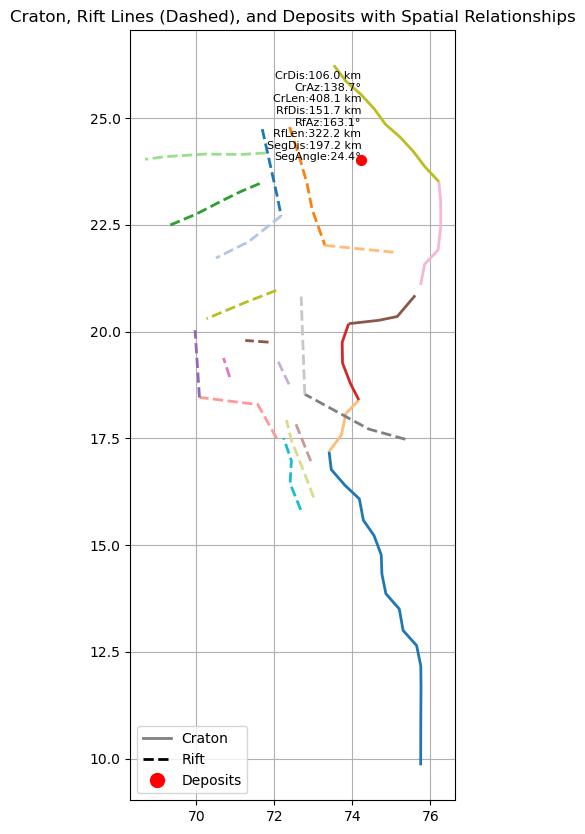

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Load the shapefiles
craton_gdf = gpd.read_file('./Datasets/merged_segmented_craton.shp')
rifts_gdf = gpd.read_file('./Datasets/merged_segmented_rift.shp')
points_gdf = gpd.read_file('./Datasets/Deposits_SpatialRelationships.shp')

# Check the CRS (Coordinate Reference System) to ensure they match
if craton_gdf.crs != rifts_gdf.crs:
    rifts_gdf = rifts_gdf.to_crs(craton_gdf.crs)
if points_gdf.crs != craton_gdf.crs:
    points_gdf = points_gdf.to_crs(craton_gdf.crs)

# Generate a unique colormap for the 'segment_id' column in craton and rift geodataframes
cmap = plt.get_cmap('tab20')  # Use a larger colormap (tab20 provides more distinct colors)
unique_segments_craton = craton_gdf['segment_id'].unique()
unique_segments_rifts = rifts_gdf['segment_id'].unique()

# Create a color dictionary for each unique segment_id
color_dict_craton = {segment: cmap(i / len(unique_segments_craton)) for i, segment in enumerate(unique_segments_craton)}
color_dict_rifts = {segment: cmap(i / len(unique_segments_rifts)) for i, segment in enumerate(unique_segments_rifts)}

# Define a default color for rift lines that are missing in the color dictionary
default_rift_color = 'black'

# Plot the Craton, Rift, and Points on a map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Craton lines with colors based on 'segment_id'
for idx, row in craton_gdf.iterrows():
    craton_color = color_dict_craton.get(row['segment_id'], 'gray')  # Use gray if no color is found
    craton_gdf.iloc[[idx]].plot(ax=ax, color=craton_color, linewidth=2)

# Plot Rift lines with dashed linestyle and colors based on 'segment_id'
for idx, row in rifts_gdf.iterrows():
    rift_color = color_dict_rifts.get(row['segment_id'], default_rift_color)  # Use default color if no match
    rifts_gdf.iloc[[idx]].plot(ax=ax, color=rift_color, linewidth=2, linestyle='--')  # Dashed linestyle

# Plot Points (with attributes)
points_gdf.plot(ax=ax, color='red', label='Deposits', markersize=50)

# Add labels for visualizing all 8 attributes at each deposit point
for idx, row in points_gdf.iterrows():
    plt.text(
        row.geometry.x, row.geometry.y,
        f"CrDis:{row['craton_dis']:.1f} km\n"
        f"CrAz:{row['craton_az']:.1f}°\n"
        f"CrLen:{row['craton_len']:.1f} km\n"
        f"RfDis:{row['rift_dis']:.1f} km\n"
        f"RfAz:{row['rift_az']:.1f}°\n"
        f"RfLen:{row['rifts_len']:.1f} km\n"
        f"SegDis:{row['seg_dis']:.1f} km\n"
        f"SegAngle:{row['seg_angle']:.1f}°",
        fontsize=8, ha='right'
    )

# Create custom legend elements for Craton, Rift, and Deposits
legend_elements = [
    Line2D([0], [0], color='gray', lw=2, label='Craton', linestyle='-'),  # Solid line for Craton
    Line2D([0], [0], color='black', lw=2, label='Rift', linestyle='--'),  # Dashed line for Rift
    Line2D([0], [0], color='red', marker='o', markersize=10, label='Deposits', linestyle='None')  # Red points for Deposits
]

# Add the legend
ax.legend(handles=legend_elements, loc='lower left')

# Set plot title and grid
plt.title('Craton, Rift Lines (Dashed), and Deposits with Spatial Relationships')
plt.grid(True)

# Show the plot
plt.show()